Importation des librairies et du dataset.

In [ ]:
!pip install pandas
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install scikit-learn
!python3 -m spacy download en_core_web_sm
!pip install matplotlib

In [3]:
import json
import spacy
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


### Attention !  Si vous voulez tester le projet merci de faire attention de bien avoir le json dans le répertoire data et de pas changer son nom merci.

Projet id: 21105 \
Project link : https://gitlab.univ-nantes.fr/E217817H/saeadmm


# Partie 1 :Nettoyage des données.
### Séparation des données et labélisation de celle-ci

In [4]:
rawData = []
with open("./data/image_review_all.json") as fichier:
    for line in fichier:
        dataTempo = json.loads(line)
        rawData.append({
            "id": dataTempo.get('user_id') + "_" + dataTempo.get('business_id'),
            "business_id": dataTempo.get('business_id'),
            "user_id": dataTempo.get('user_id'),
            "rating": dataTempo.get('rating'),
            "review_text": dataTempo.get('review_text'),
            "label": 'positif' if dataTempo.get('rating') > 2 else 'negatif'
        })
rawDF = pd.DataFrame(rawData)

### Séparation des données pour réaliser un apprentissage plus pertinent

En effet, pour réaliser un apprentissage plus pertinent, nous avons fait le choix d'avoir un dataset composé de moitié par des avis positifs et donc l'autre moitié par des avis négatifs.

In [5]:
positiveReviewDF = rawDF[rawDF['label'] == 'positif']
negativeReviewDF = rawDF[rawDF['label'] == 'negatif']
positiveReviewDF = positiveReviewDF.sample(frac=1, random_state=42)

Data = pd.concat([negativeReviewDF, positiveReviewDF.head(min(len(negativeReviewDF), len(positiveReviewDF)))])
Data = Data.dropna()
Data = Data.sample(frac=1, random_state=42)

print("Taille du DataFrame = " ,Data.shape)
Data.head()

Taille du DataFrame =  (193308, 6)


,id,business_id,user_id,rating,review_text,label
1459413,110934711920521036628_604088a37cd8bf130361dcf7,604088a37cd8bf130361dcf7,110934711920521036628,1,Why are you guys SO SLOW in the drive thru! Th...,negatif
1055668,116012958129422282207_6046b8efb0e2129e4753558b,6046b8efb0e2129e4753558b,116012958129422282207,5,We found this place from Chet Garners show The...,positif
1408465,108430402497176155594_604172957cd8bf1303625869,604172957cd8bf1303625869,108430402497176155594,5,"Beautiful atmosphere, fantastic food, okay ser...",positif
394571,101062954353697495551_60510eaada79151bfc125676,60510eaada79151bfc125676,101062954353697495551,1,Beef taco was delicious the chicken taco with ...,negatif
734176,109035487472209572473_604b56a677e81aaed3cc93a2,604b56a677e81aaed3cc93a2,109035487472209572473,1,Worst McDonald's I have ever visited,negatif


Sélection de 5 000 données pour notre apprentissage, la tokenisation étant assez longue, nous ne pouvons pas prendre le dataset entier.

In [6]:
DataForLearning = Data.head(5000)

Les données étant maintenant nettoyées, nous allons pouvoir passer à la partie 2 : Mise en place de la classification avec une méthode vue en cours (deux 
classes à prédire)

# Partie 2 : Mise en place de la classification avec un méthode vue en cours (deux classes à prédire)

Pour notre apprentissage, nous utilisons spacy et plus particulièrement son module "en_core_web_sm" car nos avis sont exclusivement en anglais. Pour ce projet, la version small du module est suffisant.

In [7]:
nlp = spacy.load("en_core_web_sm")
def tokenisation(text):
  return " ".join([token.lemma_ for token in nlp(text) if not token.is_stop])
DataForLearning["review_text"].apply(tokenisation)

1459413      guy slow drive ! bad location dining area close
1055668    find place Chet Garners daytripper . awesome p...
1408465    beautiful atmosphere , fantastic food , okay s...
394571     beef taco delicious chicken taco soft shell ho...
734176                                  Worst McDonald visit
                                 ...                        
266120     delicious paczki . order online easy . navigat...
620636     way price average food worth wait que .   orde...
435578     time , german restaurant matter . order pretze...
1429300    excellent CUISINE & AFFORDABLE & wide selectio...
1273015    savannah beer good , shrimp grit bad wife Ther...
Name: review_text, Length: 5000, dtype: object

### Première tentative pour la partie 2

Nous vectorisons ensuite nos review textes, pour cela, nous utilisons le CountVectorizer celui-ci convertit des textes en vecteurs numériques en comptant les occurrences de chaque mot, créant ainsi une représentation matricielle. Puis, nous utilisons trai_test_split comme vu en cours en effet celui-ci divise un ensemble de données en un ensemble d'entraînement et un ensemble de test, facilitant l'évaluation des performances des modèles d'apprentissage automatique en mesurant leur capacité à généraliser sur de nouvelles données. Nous utilisons cette technique pour tous nos classifier.

In [8]:
vectorizer = CountVectorizer()
reviewVectorised = vectorizer.fit_transform(DataForLearning['review_text'])
trainX, testX, trainY, testY = train_test_split(reviewVectorised,DataForLearning["label"] ,test_size=0.20)

Pour notre première tentative nous utilisions MultinomialNB en effet celui-ci est le plus approprié pour la classification de textes basée sur des comptages, comme la fréquence des mots.

In [9]:
classifier = MultinomialNB()
classifier.fit(trainX, trainY)

# Make predictions on the test set
predictions = classifier.predict(testX)

# Evaluate the model
accuracy = accuracy_score(testY, predictions)
report = classification_report(testY, predictions)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)

Accuracy: 0.884
Classification Report:
               precision    recall  f1-score   support

     negatif       0.87      0.91      0.89       513
     positif       0.90      0.86      0.88       487

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000



Pour visualiser de façon plus concrète, nous avons fait le choix de tester avec des phrases qui ne sont PAS dans le dataset original pour tester la prédiction en condition réelle.

In [10]:
test_sentences = [
    "The service was slow, and the food was tasteless.",
    "Amazing atmosphere and a diverse menu.",
    "I would not recommend this place. The service was terrible.",
    "Delicious food and friendly staff.",
]


processed_test_sentences = [
    " ".join([token.lemma_ for token in nlp(sentence) if not token.is_stop]) for sentence in test_sentences
]

test_sentences_vectorized = vectorizer.transform(processed_test_sentences)
predictions_test = classifier.predict(test_sentences_vectorized)

for sentence, prediction in zip(test_sentences, predictions_test):
    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {prediction}\n")

Sentence: The service was slow, and the food was tasteless.
Predicted Sentiment: negatif

Sentence: Amazing atmosphere and a diverse menu.
Predicted Sentiment: positif

Sentence: I would not recommend this place. The service was terrible.
Predicted Sentiment: negatif

Sentence: Delicious food and friendly staff.
Predicted Sentiment: positif



Les tests sont plus que concluants, mais pour réaliser la partie bonus, nous avons fait le choix de tester avec deux classifier différents.

### Alternative à la première tentative pour la partie 2

Pour cette première alternative, nous avons fait le choix d'utiliser KNN (k plus proche voisin) pour appliquer une technique utiliser en cours.

In [11]:



param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}


knn = KNeighborsClassifier()



grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(trainX, trainY)


print("Meilleurs hyperparamètres:", grid_search.best_params_)


knn_classifier = grid_search.best_estimator_


predictions_knn = knn_classifier.predict(testX)


accuracy_knn = accuracy_score(testY, predictions_knn)
report_knn = classification_report(testY, predictions_knn)
print("Précision avec les meilleurs hyperparamètres:", accuracy_knn)


Meilleurs hyperparamètres: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Précision avec les meilleurs hyperparamètres: 0.643


In [12]:
test_sentences = [
    "The service was slow, and the food was tasteless.",
    "Amazing atmosphere and a diverse menu.",
    "I would not recommend this place. The service was terrible.",
    "Delicious food and friendly staff.",
]
processed_test_sentences = [
    " ".join([token.lemma_ for token in nlp(sentence) if not token.is_stop]) for sentence in test_sentences
]


test_sentences_vectorized = vectorizer.transform(processed_test_sentences)


predictions_test = knn_classifier.predict(test_sentences_vectorized)


for sentence, prediction in zip(test_sentences, predictions_test):
    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {prediction}\n")

Sentence: The service was slow, and the food was tasteless.
Predicted Sentiment: positif

Sentence: Amazing atmosphere and a diverse menu.
Predicted Sentiment: positif

Sentence: I would not recommend this place. The service was terrible.
Predicted Sentiment: positif

Sentence: Delicious food and friendly staff.
Predicted Sentiment: positif



Après analyse des résultats pour les mêmes phrases et le même jeu de données d'apprentissage, le résultat est moins bon malgré un score d'accuracy d'environ 0.6-0.7

### Alternative 3 pour la partie 2 : Utilisation de SVC

In [13]:
vectorizer = CountVectorizer()
reviewVectorised = vectorizer.fit_transform(DataForLearning['review_text'])
trainX, testX, trainY, testY = train_test_split(reviewVectorised,DataForLearning["label"] ,test_size=0.20)

svm_classifier = SVC(kernel='linear') 
svm_classifier.fit(trainX, trainY)

predictions_svm = svm_classifier.predict(testX)
accuracy_svm = accuracy_score(testY, predictions_svm)
report_svm = classification_report(testY, predictions_svm)

print("Accuracy (SVM):", accuracy_svm)
print("Classification Report (SVM):\n", report_svm)

Accuracy (SVM): 0.868
Classification Report (SVM):
               precision    recall  f1-score   support

     negatif       0.90      0.85      0.87       530
     positif       0.84      0.89      0.86       470

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



In [14]:
test_sentences = [
    "The service was slow, and the food was tasteless.",
    "Amazing atmosphere and a diverse menu.",
    "I would not recommend this place. The service was terrible.",
    "Delicious food and friendly staff.",
]


processed_test_sentences = [
    " ".join([token.lemma_ for token in nlp(sentence) if not token.is_stop]) for sentence in test_sentences
]


test_sentences_vectorized = vectorizer.transform(processed_test_sentences)


predictions_test = svm_classifier.predict(test_sentences_vectorized)


for sentence, prediction in zip(test_sentences, predictions_test):
    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {prediction}\n")

Sentence: The service was slow, and the food was tasteless.
Predicted Sentiment: negatif

Sentence: Amazing atmosphere and a diverse menu.
Predicted Sentiment: positif

Sentence: I would not recommend this place. The service was terrible.
Predicted Sentiment: negatif

Sentence: Delicious food and friendly staff.
Predicted Sentiment: positif



Après analyse des résultats, nous constatons un résultat plus que concluant, il est dans la tranche de prédiction du modèle MultinomialNB.

### Après avoir fait cet apprentissage, nous allons maintenant analyser nos résultats

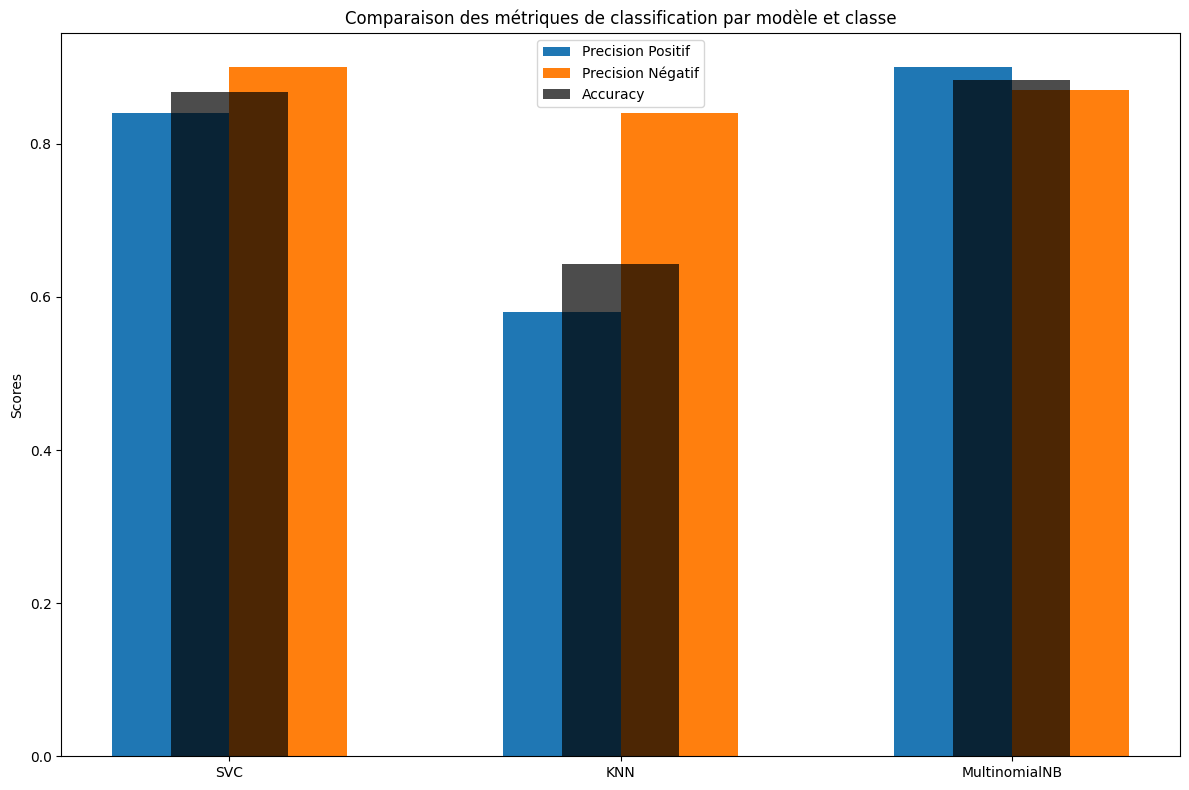

In [15]:
models = ['SVC', 'KNN', 'MultinomialNB']
reports = [report_svm, report_knn, report]
accuracies = [accuracy_svm, accuracy_knn, accuracy]

precision_pos = []
precision_neg = []

for model, report in zip(models, reports):
    lines = report.split('\n')
    
    for line in lines[2: (len(lines) - 5)]:
        s = line.split()
        if len(s) >= 2:
            if s[0] == 'positif':
                precision_pos.append(float(s[1]))
            elif s[0] == 'negatif':
                precision_neg.append(float(s[1]))


width = 0.3
x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(12, 8))


ax.bar(x - width/2, precision_pos, width, label='Precision Positif')
ax.bar(x + width/2, precision_neg, width, label='Precision Négatif')
ax.bar(x, accuracies, width, label='Accuracy', alpha=0.7, color='black')

ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylabel('Scores')
ax.set_title('Comparaison des métriques de classification par modèle et classe')
ax.legend()

plt.tight_layout()
plt.show()


Après analyse graphique, il est flagrant que SVC est le meilleur classifier dans notre cas.

# Partie 3

Pour cette partie aussi, nous allons utiliser trois classifier pour répondre au bonus.


### Première cas utilisation de MultinomialNB.

In [16]:
trainX, testX, trainY, testY = train_test_split(reviewVectorised,DataForLearning["rating"] ,test_size=0.20)

In [17]:
vectorizer = CountVectorizer()
reviewVectorised = vectorizer.fit_transform(DataForLearning['review_text'])
trainX, testX, trainY, testY = train_test_split(reviewVectorised,DataForLearning["rating"] ,test_size=0.20)
classifiernb3 = MultinomialNB()
classifiernb3.fit(trainX, trainY)


predictions_nb3 = classifiernb3.predict(testX)


accuracy_nb3 = accuracy_score(testY, predictions_nb3)
report_nb3 = classification_report(testY, predictions_nb3)

print("Accuracy:", accuracy_nb3)
print("Classification Report:\n", report_nb3)

Accuracy: 0.656
Classification Report:
               precision    recall  f1-score   support

           1       0.70      0.78      0.74       337
           2       0.42      0.41      0.41       185
           3       0.00      0.00      0.00        41
           4       0.15      0.07      0.09        86
           5       0.78      0.88      0.83       351

    accuracy                           0.66      1000
   macro avg       0.41      0.43      0.41      1000
weighted avg       0.60      0.66      0.62      1000



In [18]:
test_sentences = [
    "The service was slow, and the food was tasteless.",
    "Amazing atmosphere and a diverse menu.",
    "I would not recommend this place. The service was terrible.",
    "Delicious food and friendly staff.",
]


processed_test_sentences = [
    " ".join([token.lemma_ for token in nlp(sentence) if not token.is_stop]) for sentence in test_sentences
]

test_sentences_vectorized = vectorizer.transform(processed_test_sentences)
predictions_test = classifiernb3.predict(test_sentences_vectorized)


for sentence, prediction in zip(test_sentences, predictions_test):
    print(f"Sentence: {sentence}")
    print(f"Predicted Sentiment: {prediction}\n")

Sentence: The service was slow, and the food was tasteless.
Predicted Sentiment: 1

Sentence: Amazing atmosphere and a diverse menu.
Predicted Sentiment: 5

Sentence: I would not recommend this place. The service was terrible.
Predicted Sentiment: 1

Sentence: Delicious food and friendly staff.
Predicted Sentiment: 5



Les tests pour ce classifier sont concluants, cependant comme prévu la prédiction pour notes dites neutres (3) est quasiment impossible.

### Alternative 2 à la partie 3 : Utilisation de la méthode KNN:

In [19]:
vectorizer = CountVectorizer()
reviewVectorised = vectorizer.fit_transform(DataForLearning['review_text'])
trainX, testX, trainY, testY = train_test_split(reviewVectorised,DataForLearning["rating"] ,test_size=0.20)


param_grid = {
    'n_neighbors': [1,3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()


grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(trainX, trainY)


print("Meilleurs hyperparamètres:", grid_search.best_params_)

knn_classifier3 = grid_search.best_estimator_

predictions_knn3 = knn_classifier3.predict(testX)

accuracy_knn3 = accuracy_score(testY, predictions_knn3)
report_knn3 = classification_report(testY, predictions_knn3)
print("Précision avec les meilleurs hyperparamètres:", accuracy_knn3)

Meilleurs hyperparamètres: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Précision avec les meilleurs hyperparamètres: 0.449


Comme lors de la partie 2 ce classifier ne répond pas aux attentes fixées pour l'exercice, avec une prédiction plus que peu fiable. Suite à ce manque de résultat concluant, nous ne montrerons pas d'exemple.

### Alternative 3 pour la partie 3 : Utilisation de SVC Linear

In [20]:
vectorizer = CountVectorizer()
reviewVectorised = vectorizer.fit_transform(DataForLearning['review_text'])
trainX, testX, trainY, testY = train_test_split(reviewVectorised,DataForLearning["rating"] ,test_size=0.20)

svc3_classifier = SVC(kernel='linear')
svc3_classifier.fit(trainX, trainY)


predictions_svc3 = svc3_classifier.predict(testX)


accuracy_svc3 = accuracy_score(testY, predictions_svc3)
report_svc3 = classification_report(testY, predictions_svc3)

print("Accuracy (SVM):", accuracy_svc3)
print("Classification Report (SVM):\n", report_svc3)

Accuracy (SVM): 0.621
Classification Report (SVM):
               precision    recall  f1-score   support

           1       0.62      0.66      0.64       309
           2       0.40      0.40      0.40       204
           3       0.09      0.08      0.09        25
           4       0.48      0.36      0.41       103
           5       0.80      0.83      0.82       359

    accuracy                           0.62      1000
   macro avg       0.48      0.47      0.47      1000
weighted avg       0.61      0.62      0.62      1000



Après analyse des résultats, nous pouvons conclure que ce classifier est peu fiable, mais reste notre second plus fiable avec en moyenne 3% de score d'accuracy de différence avec MultinomialNB.

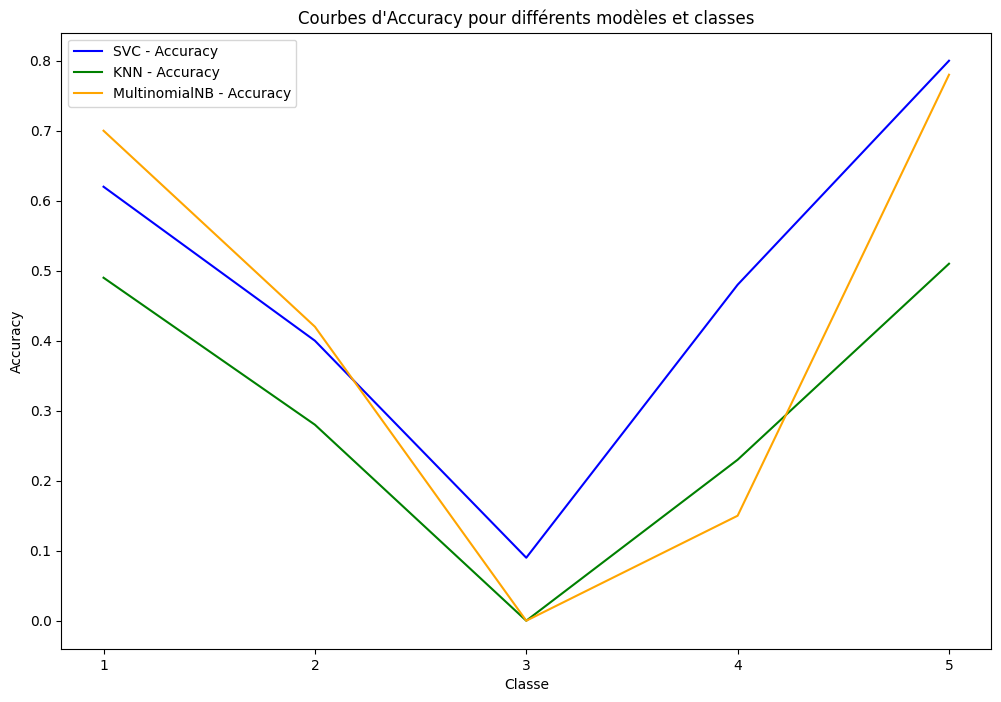

In [21]:
import matplotlib.pyplot as plt
import numpy as np


models = ['SVC', 'KNN', 'MultinomialNB']
reports = [report_svc3, report_knn3, report_nb3]


colors = ['blue', 'green', 'orange']


accuracy_pos = {model: [] for model in models}
classes = []

for i, model in enumerate(models):
    lines = reports[i].split('\n')
    
    
    for line in lines[2: (len(lines) - 5)]:
        s = line.split()
        if len(s) >= 2:
            if i == 0:  
                classes.append(s[0])
            accuracy_pos[model].append(float(s[1]))


x = np.arange(len(classes))

plt.figure(figsize=(12, 8))

for i, model in enumerate(models):
    plt.plot(x, accuracy_pos[model], label=f'{model} - Accuracy', color=colors[i])

plt.xlabel('Classe')
plt.ylabel('Accuracy')
plt.title('Courbes d\'Accuracy pour différents modèles et classes')
plt.xticks(x, classes)
plt.legend()
plt.show()


# Partie 4 : Bonus

Cette partie a été réalisée tout au long des parties 2 et 3. Via l'utilisation de différents classifier.

À partir de la documentation, j'ai tenté de résumer au mieux comment fonctionnent les différents classifier: \
 KNN fonctionne en trouvant les voisins les plus proches dans l'espace des caractéristiques pour prédire la classe d'un point, adapté à des données de dimensions moyennes à élevées. \
 SVC cherche un hyperplan optimal de séparation entre les classes, adapté aux problèmes de classification linéaire et non linéaire. \
 MultinomialNB, quant à lui, repose sur le théorème de Bayes et est particulièrement utile pour les données textuelles, modélisant la distribution multinomiale des caractéristiques